# The Dataset: Gravity Spy

The gravity spy dataset is a set of LIGO's spectrograms that have been classified by people as part of the Gravity Spy Zooniverse project.
The main purpose of this large project is the detection and classification of glitches, i.e. artifacts due to the extreme sensibility of these detectors, which are separated in different categories based on some of their features such as the shape they exhibit in the spectrograms or a typical frequency. 
Machine learing algorithms are expected to help automating the process of identifying these artifacts and discern them from interesting astrophysical events.

## About my project

In this project I am going to try three different algorithms for the classification of the images in this dataset: Support Vector Machines, Feed Forward Neural Networks and Convolutional Neural Networks. For each method I will try several models with different hyperparameters in order to study how their tuning can help reach better performances. The best models will be then compared on the validation set which will allow to ponder the differences between these algorithms highlighting their strenghts and limitations.

The code and the results obtained are divided in 4 Jupyter notebooks:
    * 
    *
    *
    *

Some functions defined in one notebook and used in some of the others are copied in the `my_utils.py` module which is then imported when needed.

## The images

Each image of the dataset has been obtained removing the axes and the colorbar from the data spectrograms. I have reported below one of the original images to provide the information missing in the Gravity Spy dataset such as the meaning of the axes.

![spectrogram with axes](images/i1.png)

The same image cropped as it would be in the dataset is shown below

![spectrogram with axes](images/i2.png)

## Classes

The dataset contains images classified in 22 classes. The following image shows one example for each of them. 

For this quick review their names are self-explanatory. 
However, the project's website host a concise guide to this classification explaining the main features that characterize each class and providing references to further resources linked with each class.


## Overview

In this section I am going to read the data to show some basic features of this dataset. The pixel dimensions of each image will also be discussed.

The data was pre-separated in three sets:

    * train set (22348 images)      - it will be used to train each one of the models that will be tested;
    
    * test set  (4720 images)       - it will be used after the training process to test the generalization 
                                      capabilities of each model and it will thus help to select 
                                      the proper hyperparameters for each algorithm used;
    
    * validation set (4800 images)  - it will be used to compare the different methods implemented



In [2]:
import numpy as np
import pandas as pd

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import resize

In [3]:
#paths
input_root = './'
test_files = f"{input_root}/test/test/"
train_files = f"{input_root}/train/train/"
val_files = f"{input_root}/validation/validation/"

#getting names of classes 

def get_class_labels():
    class_labels = pd.DataFrame(columns=['class'])
    for category in os.listdir(test_files):
        n_test = len(os.listdir(f"{test_files}{category}"))
        n_train = len(os.listdir(f"{train_files}{category}"))
        n_val = len(os.listdir(f"{val_files}{category}"))
        class_labels = class_labels.append({'class': category, 'n_test': n_test, 'n_train': n_train, 'n_val': n_val}, ignore_index=True)
    class_labels['class_id'] = class_labels.index
    return class_labels

class_labels = get_class_labels()

In [4]:
class_labels

,class,n_test,n_train,n_val,class_id
0,Paired_Doves,16.0,76.0,16.0,0
1,Low_Frequency_Burst,360.0,1748.0,376.0,1
2,Wandering_Line,28.0,116.0,24.0,2
3,Tomte,52.0,292.0,68.0,3
4,1400Ripples,36.0,236.0,52.0,4
5,Blip,1092.0,5096.0,1100.0,5
6,Whistle,180.0,832.0,184.0,6
7,1080Lines,200.0,916.0,196.0,7
8,Scratchy,200.0,948.0,200.0,8
9,Power_Line,272.0,1256.0,268.0,9


The images are not equally distributed among the 22 classes. However, their distribution among the different classes is kept the same in the 3 sets in which the data have been divided.

array([<AxesSubplot:title={'center':'n_train'}, xlabel='class'>,
       <AxesSubplot:title={'center':'n_test'}, xlabel='class'>,
       <AxesSubplot:title={'center':'n_val'}, xlabel='class'>],
      dtype=object)

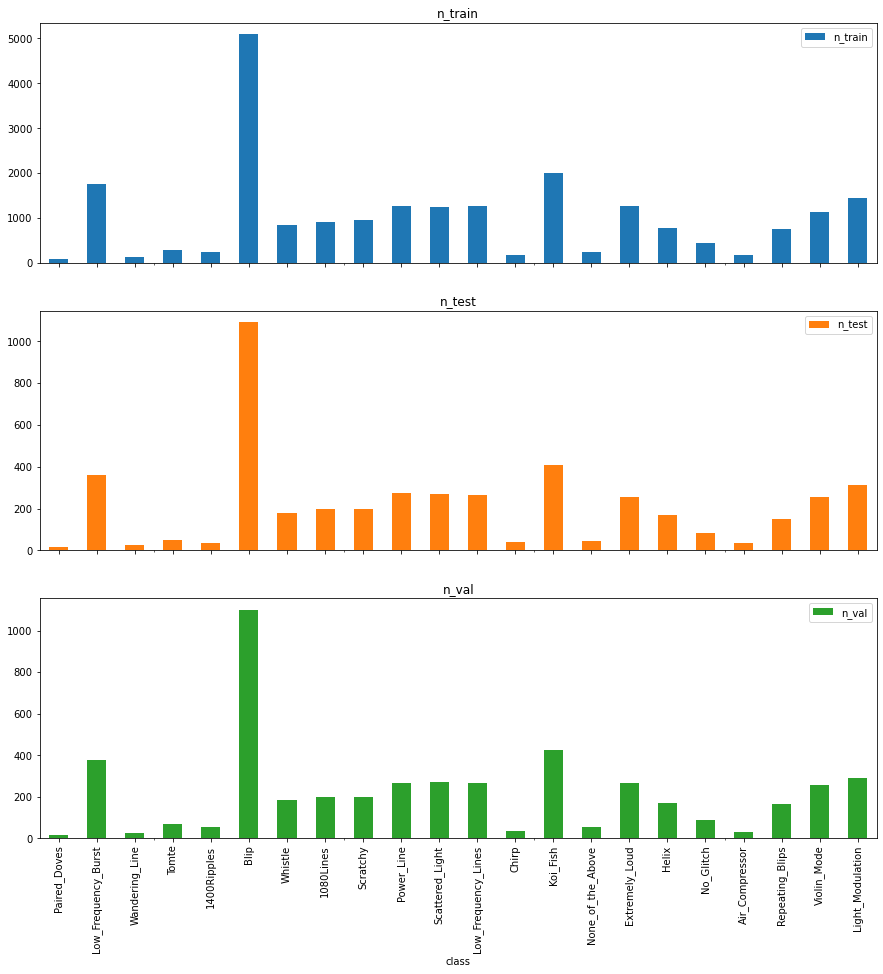

In [28]:
class_labels.plot.bar(x='class', y=['n_train', 'n_test', 'n_val'], subplots=True, figsize=(15,15))

Each image is stored in the png format. I use the imageio module to import them in a numpy array with shape
(pixel height, pixel width, channels). The first three channels contain the intensity of each one of the RGB components while the fourth one is the alpha channel which in these images is not used an therefore dropped.

Here is shown a snippet of the code used to read an image

In [50]:
import imageio as iio

path = f"{input_root}/{test_files}/Blip/H1_0H27ffyt60_spectrogram_0.5.png"
image = np.array(iio.imread(path)[:,:,:3])

In [51]:
np.shape(image)

(479, 569, 3)

In [61]:
from sys import getsizeof
print(f"Each image occupies {getsizeof(image)/1024:.2f} KiB in memory")
print(f"The sets should thus occupy respectively:")
print(f"train set: {22348*getsizeof(image)/1024/1024/1024:.2f} GiB")
print(f"test set: {4720*getsizeof(image)/1024/1024/1024:.2f} GiB")
print(f"validation set: {4800*getsizeof(image)/1024/1024/1024:.2f} GiB")

Each image occupies 798.62 KiB in memory
The sets should thus occupy respectively:
train set: 17.02 GiB
test set: 3.59 GiB
validation set: 3.66 GiB


The size of the training set exceeds the memory capacity of the device I am using for the analysis of this dataset which would ths be required to use the swap memory for the training process with a significant loss of performance. In order to avoid excessively long training times some data reduction is required.

Note that the actual size of the images is much lower, probably due to the compression algorithms and different, more efficient, representation of the data used in the png format. 
The array gets inflated during the conversion in a numpy array.

The following function resize all the images in a desired size saving them after the process. As a first attempt I resized every 479x569 pixels image to 60x71 pixels dividing each dimension by a factor of 8.

In [62]:
#function that reads data
from tqdm import tqdm
def resize_images(source_dir, dest_dir, new_size):
    data = pd.DataFrame(columns=['class', 'path'])
    for dirname in tqdm(os.listdir(source_dir)):
        os.mkdir(f"{dest_dir}{dirname}")
        for filename in tqdm(os.listdir(f"{source_dir}{dirname}")):
            path_in = f"{source_dir}{dirname}{filename}"
            path_out = f"{dest_dir}{dirname}{filename}"
            x = resize(iio.imread(path_in)[:,:,:3], new_size)
            iio.imwrite(x, path_out)

In [ ]:
res_test_files = f"{input_root}/test/test_60.71/"
res_train_files = f"{input_root}/train/train_60.71/"
res_val_files = f"{input_root}/validation/validation_60.71/"

os.mkdir(res_test_files)
os.mkdir(res_train_files)
os.mkdir(res_val_files)

The following function can be used to retrieve a set of images ready to be used for training machine learning models

In [5]:
#function that reads data
from tqdm import tqdm
def get_images(source_dir, class_labels=None, new_size=None):
    if class_labels == None:
        class_labels = get_class_labels()

    data = pd.DataFrame(columns=['class', 'path'])
    for dirname in os.listdir(r_dir):
        for filename in os.listdir(f"{r_dir}{dirname}"):
            data = data.append({'class': dirname, 'path': f"{r_dir}/{dirname}/{filename}"}, ignore_index=True)
    
    data = data.merge(class_labels, on='class', how='left')
    
    y = np.array(data['class_id'])
    x = [iio.imread(path)[:,:,:3] for path in tqdm(data['path'].to_list())]

    return x, y, data

In [ ]:
from sklearn.svm import SVC

classifier = SVC(kernel='linear')
classifier.fit(x_test, y_test)

# References